In [89]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import tqdm
import pdb
from scipy.sparse import csr_matrix, linalg
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import warnings

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
#import lightgbm as lgb

import random
import os
import re

import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler

from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor

from sklearn.metrics import mean_absolute_error

warnings.filterwarnings(action='ignore')

In [90]:
path= '../data/'

users = pd.read_csv(path+'users.csv')
books = pd.read_csv(path+'books.csv')
train_ratings = pd.read_csv(path+'train_ratings.csv')
test_ratings = pd.read_csv(path+'test_ratings.csv')
submit = pd.read_csv(path + 'sample_submission.csv')


def rmse(real: list, predict: list) -> float:
    pred = np.array(predict)
    return np.sqrt(np.mean((real-pred) ** 2))

SEED = 42
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

seed_everything(SEED)

print('users shape: ', users.shape)
print('books shape: ', books.shape)
print('train_ratings shape: ', train_ratings.shape)

users shape:  (68092, 3)
books shape:  (149570, 10)
train_ratings shape:  (306795, 3)


# 데이터 전처리

## book 테이블

In [91]:
# books 테이블 전처리 부분 입니다.
# books의 이미지 변수를 지워줍니다.
# 제목과 요약 내용 변수를 지웁니다. 
# (이 변수들은 추후 사용 가능할수도 있으나 일단 지웁니다.)
# books의 publisher 변수 중 이름이 비슷한 변수들을 찾아 하나로 통일해줍니다.
books.drop(['book_title', 'summary', 'img_url', 'img_path'], axis = 1, inplace = True)

books_publishers = books.groupby('publisher')['isbn'].count().sort_values(ascending=False)
for i in books_publishers[books_publishers > 20].index: # 20 말고 10으로 하면 오류가 남..
    books['publisher'][books['publisher'].str.contains(i)] = i

In [92]:
# books의 카테고리 부분.

# 대괄호 써있는 카테고리 전치리
books.loc[books[books['category'].notnull()].index, 'category'] = books[books['category'].notnull()]['category'].apply(lambda x: re.sub('[\W_]+',' ',x).strip())
# 모두 소문자로 통일
books['category'] = books['category'].str.lower()

# 수작업으로 higt 카테고리로 통합
categories = ['garden','crafts','physics','adventure','music','fiction','nonfiction','science','science fiction','social','homicide',
 'sociology','disease','religion','christian','philosophy','psycholog','mathemat','agricult','environmental',
 'business','poetry','drama','literary','travel','motion picture','children','cook','literature','electronic',
 'humor','animal','bird','photograph','computer','house','ecology','family','architect','camp','criminal','language','india']

books['category_high'] = books['category'].copy()
for category in categories:
    books.loc[books[books['category'].str.contains(category,na=False)].index,'category_high'] = category

In [93]:
books['category_high'].value_counts()

fiction                                            39678
biography autobiography                             3326
history                                             1927
religion                                            1824
nonfiction                                          1427
                                                   ...  
buddhismus                                             1
heller jettero fictitious character                    1
persian gulf                                           1
procedure law                                          1
authors canadian english 20th century biography        1
Name: category_high, Length: 3270, dtype: int64

In [94]:
# language와 category_high NULL 값을 최빈값으로 채웁니다.
# 근거 : language == en일 때, category_high == fiction 일 때와
# 근거 : 값이 NULL 일 때 rating 평균이 7.0x로 유사한 형태.
books['language'].fillna('en', inplace = True)
books['category_high'].fillna('fiction', inplace = True)

In [95]:
# 출판연도 1970, 1980, 1990, 2000, 2020 으로 범주화 시킵니다.
# 딥러닝 과정에서 범주화 시키는 것이 유리합니다.
# 근거 : develop 파일에서 여러번 실험 결과 본 기준이 가장 rating을 잘 구분함.

books['years'] = books['year_of_publication'].copy()
books['years'][books['year_of_publication'] < 1970] = 1970
books['years'][(books['year_of_publication'] < 1980) * (books['year_of_publication'] >= 1970)] = 1980
books['years'][(books['year_of_publication'] < 1990) * (books['year_of_publication'] >= 1980)] = 1990
books['years'][(books['year_of_publication'] < 2000) * (books['year_of_publication'] >= 1990)] = 2000
books['years'][(books['year_of_publication'] >= 2000)] = 2020
books['years'] = books['years'].astype('str')
#books['years'] = books['years'].astype('int')
books.drop(['year_of_publication', 'category'], axis = 1, inplace = True)

## user 테이블

In [96]:
users['location'] = users['location'].str.replace(r'[^0-9a-zA-Z:,]', '') # 특수문자 제거

users['location_city'] = users['location'].apply(lambda x: x.split(',')[0].strip())
users['location_state'] = users['location'].apply(lambda x: x.split(',')[1].strip())
users['location_country'] = users['location'].apply(lambda x: x.split(',')[2].strip())

users = users.replace('na', np.nan) #특수문자 제거로 n/a가 na로 바뀌게 되었습니다. 따라서 이를 컴퓨터가 인식할 수 있는 결측값으로 변환합니다.
users = users.replace('', np.nan) # 일부 경우 , , ,으로 입력된 경우가 있었으므로 이런 경우에도 결측값으로 변환합니다.

modify_location = users[(users['location_country'].isna())&(users['location_city'].notnull())]['location_city'].values
location = users[(users['location'].str.contains('seattle'))&(users['location_country'].notnull())]['location'].value_counts().index[0]

location_list = []
for location in modify_location:
    try:
        right_location = users[(users['location'].str.contains(location))&(users['location_country'].notnull())]['location'].value_counts().index[0]
        location_list.append(right_location)
    except:
        pass

for location in location_list:
    users.loc[users[users['location_city']==location.split(',')[0]].index,'location_state'] = location.split(',')[1]
    users.loc[users[users['location_city']==location.split(',')[0]].index,'location_country'] = location.split(',')[2]

loc_city2idx = {v:k for k,v in enumerate(users['location_city'].unique())}
loc_state2idx = {v:k for k,v in enumerate(users['location_state'].unique())}
loc_country2idx = {v:k for k,v in enumerate(users['location_country'].unique())}

users['location_city'] = users['location_city'].map(loc_city2idx)
users['location_state'] = users['location_state'].map(loc_state2idx)
users['location_country'] = users['location_country'].map(loc_country2idx)

users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68092 entries, 0 to 68091
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   user_id           68092 non-null  int64  
 1   location          68092 non-null  object 
 2   age               40259 non-null  float64
 3   location_city     68092 non-null  int64  
 4   location_state    68092 non-null  int64  
 5   location_country  68092 non-null  int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 3.1+ MB


In [97]:
users['fix_age'] = users['age'].copy()
users['fix_age'][users['age'] < 10] = 10
users['fix_age'][(users['age'] < 20) & (users['age'] >= 10)] = 20
users['fix_age'][(users['age'] < 30) & (users['age'] >= 20)] = 30
users['fix_age'][(users['age'] < 35) & (users['age'] >= 30)] = 35
users['fix_age'][(users['age'] < 40) & (users['age'] >= 35)] = 40
users['fix_age'][(users['age'] < 50) & (users['age'] >= 40)] = 50
users['fix_age'][users['age'] >= 50] = 100
users['fix_age'].fillna(10, inplace = True)
users['fix_age'] = users['fix_age'].astype('str') # users['fix_age'] = users['fix_age'].astype('int')

In [98]:
users = users[['user_id', 'location_city', 'location_state', 'location_country','fix_age']]
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68092 entries, 0 to 68091
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   user_id           68092 non-null  int64 
 1   location_city     68092 non-null  int64 
 2   location_state    68092 non-null  int64 
 3   location_country  68092 non-null  int64 
 4   fix_age           68092 non-null  object
dtypes: int64(4), object(1)
memory usage: 2.6+ MB


## rating 테이블과 merge

In [102]:
# 전처리 완료한 books와 users 테이블을 이용해 rating 테이블과 merge 하기.
train_ratings = pd.read_csv(path+'train_ratings.csv')
test_ratings = pd.read_csv(path+'test_ratings.csv')

train_ratings = pd.merge(train_ratings,books, how='right',on='isbn')
train_ratings.dropna(subset=['rating'], inplace = True)
train_ratings = pd.merge(train_ratings, users, how='right',on='user_id')
train_ratings.dropna(subset=['rating'], inplace = True)

test_ratings['index'] = test_ratings.index
test_ratings = pd.merge(test_ratings,books, how='right',on='isbn')
test_ratings.dropna(subset=['rating'], inplace = True)
test_ratings = pd.merge(test_ratings, users, how='right',on='user_id')
test_ratings.dropna(subset=['rating'], inplace = True)
test_ratings = test_ratings.sort_values('index')
test_ratings.drop(['index'], axis=1, inplace=True)

train_ratings['user_id'] = train_ratings['user_id'].astype('str')
test_ratings['user_id'] = test_ratings['user_id'].astype('str')

train_ratings['location_city'] = train_ratings['location_city'].astype('str')
test_ratings['location_city'] = test_ratings['location_city'].astype('str')

train_ratings['location_state'] = train_ratings['location_state'].astype('str')
test_ratings['location_state'] = test_ratings['location_state'].astype('str')

train_ratings['location_country'] = train_ratings['location_country'].astype('str')
test_ratings['location_country'] = test_ratings['location_country'].astype('str')


# 모델링

In [108]:
# params_cat = {
#             "task_type" : "GPU",
#             "devices" : '0',
#             "random_state": SEED,
#             "learning_rate": 0.05,
#             "n_estimators": 2000,
#             "verbose" : 1,
#             "objective" : "RMSE",
#             "max_depth": 10,#trial.suggest_int("max_depth", 1, 16),
#             "colsample_bylevel": 1,#trial.suggest_float("colsample_bylevel", 0.8, 1.0),
#             #"subsample": 0.8, #trial.suggest_float("subsample", 0.3, 1.0), GPU 사용시 안될수도.
#             "min_child_samples": 50, #trial.suggest_int("min_child_samples", 5, 100),
#             "max_bin": 300, #trial.suggest_int("max_bin", 200, 500),
#             "cat_features" : list(train_ratings.drop(['rating'],axis = 1).columns)
#     }

params_cat = {
    "task_type" : "GPU",
    "devices" : '0',
    "random_seed": SEED,
    'learning_rate': 0.04574578205475402, 
    'bagging_temperature': 0.12172958098369972, 
    'n_estimators': 8459, 
    'max_depth': 8, 
    'random_strength': 28, 
    'l2_leaf_reg': 1.6285455533915874e-05, 
    'min_child_samples': 18, 
    'max_bin': 441, 
    'od_type': 'Iter',
    "cat_features" : list(train_ratings.drop(['rating'],axis = 1).columns),
}

X_tr, X_val, y_tr, y_val = train_test_split(train_ratings.drop(['rating'],axis = 1), train_ratings['rating'], test_size=0.2,random_state= 42)

model = CatBoostRegressor(**params_cat)
model.fit(
    X_tr,
    y_tr,
    eval_set=[(X_val, y_val)],
    #early_stopping_rounds=10,
    verbose=False,
)

cat_pred = model.predict(X_val)
log_score = rmse(y_val, cat_pred)

print(log_score)

2.1364121736105117


In [101]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=SEED)
train_ratings.reset_index(drop = True, inplace = True)
train_ratings = train_ratings.reset_index()

folds = []
fold = 0
train_ratings['fold'] = fold
for _, valid_idx in skf.split(train_ratings, train_ratings['rating']):
    fold += 1
    train_ratings['fold'][train_ratings['index'].isin(valid_idx)] = fold
train_ratings.drop(['index'], axis = 1, inplace = True)
train_ratings['fold']

0         5
1         3
2         2
3         1
4         3
         ..
306790    1
306791    3
306792    4
306793    3
306794    4
Name: fold, Length: 306795, dtype: int64

In [74]:
random.seed(SEED)
cat_models={}

cat_features = list(range(1, 10))

def objective(trial):
    param = {
        "random_seed": SEED,
        "objective" : "RMSE",
        "cat_features" : list(train_ratings.drop(['rating', 'fold'],axis = 1).columns),
        'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.5),
        'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),
        "n_estimators":trial.suggest_int("n_estimators", 1000, 10000),
        "max_depth":trial.suggest_int("max_depth", 4, 16),
        'random_strength' :trial.suggest_int('random_strength', 0, 100),
    #   "colsample_bylevel":trial.suggest_float("colsample_bylevel", 0.4, 1.0), 이거 때메 GPU 안돌아감
        "l2_leaf_reg":trial.suggest_float("l2_leaf_reg",1e-8,3e-5),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "max_bin": trial.suggest_int("max_bin", 200, 500),
        'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
    }

    model = CatBoostRegressor(**param, task_type = 'GPU', devices = '0')

    model.fit(
        X_train,
        y_train,
        eval_set=[(X_valid, y_valid)],
        verbose=100
    )

    cat_pred = model.predict(X_valid)
    log_score = rmse(y_valid, cat_pred)

    return log_score

for fold in range(1,3):
    print(f'===================================={fold}============================================')
    X_train = train_ratings[train_ratings['fold'] != fold].drop(['fold', 'rating'],axis = 1)
    X_valid = train_ratings[train_ratings['fold'] == fold].drop(['fold', 'rating'],axis = 1)
    y_train = train_ratings[train_ratings['fold'] != fold]['rating']
    y_valid = train_ratings[train_ratings['fold'] == fold]['rating']

    sampler = optuna.samplers.TPESampler(seed=42)
    study = optuna.create_study(
        study_name = 'cat_parameter_opt',
        direction = 'minimize',
        sampler = sampler,
    )
    study.optimize(objective, n_trials=10)


    model = CatBoostRegressor(**study.best_params, task_type = 'GPU', devices = '0', random_state = SEED, objective = 'RMSE', cat_features = list(train_ratings.drop(['rating'],axis = 1).columns))
    model.fit(X_train, y_train)
                
    pred = model.predict(test_ratings.drop(['rating'],axis = 1))
    test_ratings[f'pred_{fold}'] = pred
    print(f'================================================================================\n\n')

====================================2============================================


[I 2022-11-03 02:42:43,765] A new study created in memory with name: cat_parameter_opt


0:	learn: 2.4327164	test: 2.4326488	best: 2.4326488 (0)	total: 15.7ms	remaining: 1m 59s
100:	learn: 2.4273628	test: 2.4257219	best: 2.4257219 (100)	total: 1.39s	remaining: 1m 43s
200:	learn: 2.4273615	test: 2.4257040	best: 2.4257040 (199)	total: 2.65s	remaining: 1m 37s
bestTest = 2.425703788
bestIteration = 216
Shrink model to first 217 iterations.


[I 2022-11-03 02:42:49,348] Trial 0 finished with value: 2.425704035595101 and parameters: {'learning_rate': 0.043284502212938815, 'bagging_temperature': 63.512210106407046, 'n_estimators': 7588, 'max_depth': 11, 'random_strength': 15, 'l2_leaf_reg': 4.688275664882717e-06, 'min_child_samples': 10, 'max_bin': 460, 'od_type': 'Iter'}. Best is trial 0 with value: 2.425704035595101.


0:	learn: 2.4330855	test: 2.4330774	best: 2.4330774 (0)	total: 13.8ms	remaining: 1m 56s
100:	learn: 2.4280096	test: 2.4268675	best: 2.4268675 (100)	total: 1.22s	remaining: 1m 41s
200:	learn: 2.4274342	test: 2.4259461	best: 2.4259461 (200)	total: 2.43s	remaining: 1m 40s
300:	learn: 2.4273699	test: 2.4257686	best: 2.4257686 (300)	total: 3.63s	remaining: 1m 38s
400:	learn: 2.4273630	test: 2.4257236	best: 2.4257236 (400)	total: 5s	remaining: 1m 40s
500:	learn: 2.4273615	test: 2.4257103	best: 2.4257103 (500)	total: 6.27s	remaining: 1m 39s
600:	learn: 2.4273614	test: 2.4257061	best: 2.4257061 (597)	total: 7.53s	remaining: 1m 38s
700:	learn: 2.4273616	test: 2.4257048	best: 2.4257047 (669)	total: 8.86s	remaining: 1m 38s
800:	learn: 2.4273615	test: 2.4257041	best: 2.4257040 (798)	total: 10.1s	remaining: 1m 36s
900:	learn: 2.4273616	test: 2.4257040	best: 2.4257040 (798)	total: 11.3s	remaining: 1m 35s
1000:	learn: 2.4273616	test: 2.4257040	best: 2.4257040 (798)	total: 12.6s	remaining: 1m 33s
1100

[W 2022-11-03 02:43:43,211] Trial 1 failed because of the following error: KeyboardInterrupt('')
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_22233/1481186031.py", line 25, in objective
    model.fit(
  File "/opt/conda/lib/python3.8/site-packages/catboost/core.py", line 5730, in fit
    return self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline,
  File "/opt/conda/lib/python3.8/site-packages/catboost/core.py", line 2355, in _fit
    self._train(
  File "/opt/conda/lib/python3.8/site-packages/catboost/core.py", line 1759, in _train
    self._object._train(train_pool, test_pool, params, allow_clear_pool, init_model._object if init_model else None)
  File "_catboost.pyx", line 4622, in _catboost._CatBoost._train
  File "_catboost.pyx", line 4671, in _catboost._CatBoost._train
Ke

KeyboardInterrupt: 

In [20]:
test_ratings['rating'] = (test_ratings['pred_0'] + test_ratings['pred_1'] + test_ratings['pred_2'] + test_ratings['pred_3'] + test_ratings['pred_4']) / 5
test = test_ratings[['user_id', 'isbn', 'rating']]
test.to_csv('../submit/KSY_5KFold_Optima2.csv', index = False)
test_ratings.to_csv('../data/KSY_5KFold_Optima2.csv', index = False)

In [161]:
test.to_csv('../submit/KSY_5KFold_Optima.csv', index = False)

In [36]:
def objective(trial):
    param = {
        "random_state":42,
        "objective" : "RMSE",
        'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.5),
        'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),
        "n_estimators":trial.suggest_int("n_estimators", 1000, 10000),
        "max_depth":trial.suggest_int("max_depth", 4, 16),
        'random_strength' :trial.suggest_int('random_strength', 0, 100),
    #   "colsample_bylevel":trial.suggest_float("colsample_bylevel", 0.4, 1.0), 이거 때메 GPU 안돌아감
        "l2_leaf_reg":trial.suggest_float("l2_leaf_reg",1e-8,3e-5),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "max_bin": trial.suggest_int("max_bin", 200, 500),
        'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
    }
    train_x, val_x, train_y, val_y = train_test_split(train_ratings.drop(['rating'],axis = 1), train_ratings['rating'], test_size=0.2)

    model = CatBoostRegressor(**param, task_type = 'GPU')

    model.fit(
        train_x,
        train_y,
        eval_set=[(val_x, val_y)],
        cat_features = list(train_ratings.drop(['rating'],axis = 1).columns),
        verbose=100
    )

    cat_pred = model.predict(val_x)
    log_score = rmse(val_y, cat_pred)

    return log_score

In [37]:
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(
    study_name = 'cat_parameter_opt',
    direction = 'minimize',
    sampler = sampler,
)
study.optimize(objective, n_trials=10)
print("Best Score:",study.best_value)
print("Best trial",study.best_trial.params)

[I 2022-10-31 06:52:02,076] A new study created in memory with name: cat_parameter_opt


0:	learn: 2.4299163	test: 2.4436516	best: 2.4436516 (0)	total: 12.2ms	remaining: 1m 32s
100:	learn: 2.4241328	test: 2.4367401	best: 2.4367401 (100)	total: 1.1s	remaining: 1m 21s
200:	learn: 2.4241323	test: 2.4367285	best: 2.4367283 (195)	total: 2.13s	remaining: 1m 18s
bestTest = 2.436728266
bestIteration = 195
Shrink model to first 196 iterations.


[I 2022-10-31 06:52:07,008] Trial 0 finished with value: 2.436728570644674 and parameters: {'learning_rate': 0.043284502212938815, 'bagging_temperature': 63.512210106407046, 'n_estimators': 7588, 'max_depth': 11, 'random_strength': 15, 'l2_leaf_reg': 4.688275664882717e-06, 'min_child_samples': 10, 'max_bin': 460, 'od_type': 'Iter'}. Best is trial 0 with value: 2.436728570644674.


0:	learn: 2.4371201	test: 2.4168686	best: 2.4168686 (0)	total: 11.5ms	remaining: 1m 38s
100:	learn: 2.4318873	test: 2.4108430	best: 2.4108430 (100)	total: 1.09s	remaining: 1m 30s
200:	learn: 2.4312950	test: 2.4100490	best: 2.4100490 (200)	total: 2.12s	remaining: 1m 27s
300:	learn: 2.4312282	test: 2.4099218	best: 2.4099218 (300)	total: 3.15s	remaining: 1m 25s
400:	learn: 2.4312206	test: 2.4098947	best: 2.4098947 (399)	total: 4.17s	remaining: 1m 24s
500:	learn: 2.4312196	test: 2.4098874	best: 2.4098873 (498)	total: 5.19s	remaining: 1m 22s
600:	learn: 2.4312198	test: 2.4098851	best: 2.4098851 (600)	total: 6.21s	remaining: 1m 21s
700:	learn: 2.4312198	test: 2.4098845	best: 2.4098843 (677)	total: 7.36s	remaining: 1m 21s
800:	learn: 2.4312197	test: 2.4098842	best: 2.4098841 (749)	total: 8.44s	remaining: 1m 21s
900:	learn: 2.4312197	test: 2.4098842	best: 2.4098841 (749)	total: 9.53s	remaining: 1m 20s
1000:	learn: 2.4312197	test: 2.4098842	best: 2.4098841 (749)	total: 10.6s	remaining: 1m 19s
1

[I 2022-10-31 06:53:37,674] Trial 1 finished with value: 2.4098842347953213 and parameters: {'learning_rate': 0.01083858126934475, 'bagging_temperature': 75.7947995334801, 'n_estimators': 8492, 'max_depth': 6, 'random_strength': 18, 'l2_leaf_reg': 5.51030125050448e-06, 'min_child_samples': 34, 'max_bin': 357, 'od_type': 'IncToDec'}. Best is trial 1 with value: 2.4098842347953213.


0:	learn: 2.4032016	test: 2.3994301	best: 2.3994301 (0)	total: 24ms	remaining: 1m 26s
100:	learn: 2.1866128	test: 2.1590962	best: 2.1590962 (100)	total: 2.29s	remaining: 1m 20s
200:	learn: 2.1655923	test: 2.1524100	best: 2.1524063 (199)	total: 4.38s	remaining: 1m 14s
300:	learn: 2.1489794	test: 2.1501780	best: 2.1501333 (299)	total: 6.42s	remaining: 1m 10s
400:	learn: 2.1353622	test: 2.1496276	best: 2.1496099 (395)	total: 8.5s	remaining: 1m 8s
500:	learn: 2.1230593	test: 2.1490664	best: 2.1490596 (499)	total: 10.5s	remaining: 1m 5s
600:	learn: 2.1126525	test: 2.1489714	best: 2.1484382 (557)	total: 12.6s	remaining: 1m 3s
700:	learn: 2.1020280	test: 2.1488732	best: 2.1484382 (557)	total: 14.7s	remaining: 1m 1s
800:	learn: 2.0922564	test: 2.1488451	best: 2.1484382 (557)	total: 16.9s	remaining: 59.5s
900:	learn: 2.0823179	test: 2.1490355	best: 2.1484382 (557)	total: 19s	remaining: 57.5s
1000:	learn: 2.0723083	test: 2.1494827	best: 2.1484382 (557)	total: 21.1s	remaining: 55.4s
1100:	learn: 

[I 2022-10-31 06:54:58,119] Trial 2 finished with value: 2.1484382507709117 and parameters: {'learning_rate': 0.10952662748632554, 'bagging_temperature': 0.03613894271216528, 'n_estimators': 3629, 'max_depth': 8, 'random_strength': 46, 'l2_leaf_reg': 2.355742708217648e-05, 'min_child_samples': 24, 'max_bin': 354, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.1484382507709117.


0:	learn: 2.3980752	test: 2.3969462	best: 2.3969462 (0)	total: 449ms	remaining: 11m 51s
100:	learn: 2.0410441	test: 2.1582968	best: 2.1582656 (99)	total: 44.2s	remaining: 10m 48s
200:	learn: 1.7228577	test: 2.1743537	best: 2.1582656 (99)	total: 1m 28s	remaining: 10m 11s
300:	learn: 1.3727758	test: 2.2054256	best: 2.1582656 (99)	total: 2m 14s	remaining: 9m 32s
400:	learn: 1.1330356	test: 2.2282211	best: 2.1582656 (99)	total: 2m 59s	remaining: 8m 50s
500:	learn: 0.9555684	test: 2.2413233	best: 2.1582656 (99)	total: 3m 44s	remaining: 8m 6s
600:	learn: 0.8218940	test: 2.2526077	best: 2.1582656 (99)	total: 4m 29s	remaining: 7m 21s
700:	learn: 0.7230621	test: 2.2606388	best: 2.1582656 (99)	total: 5m 14s	remaining: 6m 37s
800:	learn: 0.6353900	test: 2.2668833	best: 2.1582656 (99)	total: 5m 59s	remaining: 5m 52s
900:	learn: 0.5620606	test: 2.2721376	best: 2.1582656 (99)	total: 6m 45s	remaining: 5m 7s
1000:	learn: 0.4979032	test: 2.2766698	best: 2.1582656 (99)	total: 7m 30s	remaining: 4m 22s
11

[I 2022-10-31 07:06:55,919] Trial 3 finished with value: 2.1582656509395948 and parameters: {'learning_rate': 0.10769622478263129, 'bagging_temperature': 0.04809461967501574, 'n_estimators': 1585, 'max_depth': 16, 'random_strength': 97, 'l2_leaf_reg': 2.425383647001267e-05, 'min_child_samples': 34, 'max_bin': 229, 'od_type': 'IncToDec'}. Best is trial 2 with value: 2.1484382507709117.


0:	learn: 2.4254027	test: 2.4377824	best: 2.4377824 (0)	total: 239ms	remaining: 5m 12s
100:	learn: 2.2052319	test: 2.2068377	best: 2.2068377 (100)	total: 24s	remaining: 4m 46s
200:	learn: 2.1481846	test: 2.1674578	best: 2.1674578 (200)	total: 47.9s	remaining: 4m 24s
300:	learn: 2.1171201	test: 2.1570493	best: 2.1570493 (300)	total: 1m 12s	remaining: 4m 2s
400:	learn: 2.0913372	test: 2.1527164	best: 2.1527164 (400)	total: 1m 36s	remaining: 3m 38s
500:	learn: 2.0635245	test: 2.1498113	best: 2.1498113 (500)	total: 2m 1s	remaining: 3m 15s
600:	learn: 2.0417858	test: 2.1482712	best: 2.1482712 (600)	total: 2m 25s	remaining: 2m 51s
700:	learn: 2.0167233	test: 2.1471554	best: 2.1471554 (700)	total: 2m 50s	remaining: 2m 27s
800:	learn: 1.9887362	test: 2.1462491	best: 2.1462313 (798)	total: 3m 14s	remaining: 2m 3s
900:	learn: 1.9547306	test: 2.1458039	best: 2.1458013 (882)	total: 3m 38s	remaining: 1m 38s
1000:	learn: 1.9108126	test: 2.1461154	best: 2.1457226 (952)	total: 4m 2s	remaining: 1m 14s


[I 2022-10-31 07:12:20,104] Trial 4 finished with value: 2.145722487694836 and parameters: {'learning_rate': 0.016119044727609194, 'bagging_temperature': 0.9565499215943827, 'n_estimators': 1309, 'max_depth': 15, 'random_strength': 26, 'l2_leaf_reg': 1.987904330777592e-05, 'min_child_samples': 34, 'max_bin': 356, 'od_type': 'IncToDec'}. Best is trial 4 with value: 2.145722487694836.


0:	learn: 2.3818199	test: 2.3998469	best: 2.3998469 (0)	total: 265ms	remaining: 41m 43s
bestTest = 2.299899188
bestIteration = 21
Shrink model to first 22 iterations.


[I 2022-10-31 07:12:32,532] Trial 5 finished with value: 2.2998992793618434 and parameters: {'learning_rate': 0.4439102767051397, 'bagging_temperature': 12.60466458564947, 'n_estimators': 9456, 'max_depth': 15, 'random_strength': 60, 'l2_leaf_reg': 2.7657008308343274e-05, 'min_child_samples': 13, 'max_bin': 258, 'od_type': 'Iter'}. Best is trial 4 with value: 2.145722487694836.


0:	learn: 2.4187281	test: 2.4249871	best: 2.4249871 (0)	total: 24.3ms	remaining: 3m 25s
100:	learn: 2.2032605	test: 2.1662743	best: 2.1662743 (100)	total: 2.23s	remaining: 3m 4s
200:	learn: 2.1916086	test: 2.1565030	best: 2.1565030 (200)	total: 4.51s	remaining: 3m 5s
300:	learn: 2.1843973	test: 2.1532900	best: 2.1532900 (300)	total: 6.79s	remaining: 3m 4s
400:	learn: 2.1743721	test: 2.1497784	best: 2.1497784 (400)	total: 8.8s	remaining: 2m 56s
500:	learn: 2.1657125	test: 2.1476126	best: 2.1476062 (499)	total: 10.8s	remaining: 2m 51s
600:	learn: 2.1581979	test: 2.1463094	best: 2.1463094 (600)	total: 12.8s	remaining: 2m 47s
700:	learn: 2.1514206	test: 2.1455678	best: 2.1455436 (697)	total: 14.8s	remaining: 2m 43s
bestTest = 2.145091959
bestIteration = 771
Shrink model to first 772 iterations.


[I 2022-10-31 07:12:52,668] Trial 6 finished with value: 2.1450919437183678 and parameters: {'learning_rate': 0.04574578205475402, 'bagging_temperature': 0.12172958098369972, 'n_estimators': 8459, 'max_depth': 8, 'random_strength': 28, 'l2_leaf_reg': 1.6285455533915874e-05, 'min_child_samples': 18, 'max_bin': 441, 'od_type': 'Iter'}. Best is trial 6 with value: 2.1450919437183678.


0:	learn: 2.3781804	test: 2.3594666	best: 2.3594666 (0)	total: 134ms	remaining: 2m 20s
100:	learn: 1.8928360	test: 2.1676795	best: 2.1518258 (62)	total: 13.7s	remaining: 2m 8s
200:	learn: 1.4978165	test: 2.2176742	best: 2.1518258 (62)	total: 27.1s	remaining: 1m 54s
300:	learn: 1.2166578	test: 2.2536540	best: 2.1518258 (62)	total: 40.8s	remaining: 1m 41s
400:	learn: 1.0224806	test: 2.2769944	best: 2.1518258 (62)	total: 54.4s	remaining: 1m 27s
500:	learn: 0.8685584	test: 2.2948327	best: 2.1518258 (62)	total: 1m 7s	remaining: 1m 14s
600:	learn: 0.7403358	test: 2.3075726	best: 2.1518258 (62)	total: 1m 21s	remaining: 1m
700:	learn: 0.6475227	test: 2.3161157	best: 2.1518258 (62)	total: 1m 34s	remaining: 47s
800:	learn: 0.5625975	test: 2.3240147	best: 2.1518258 (62)	total: 1m 48s	remaining: 33.5s
900:	learn: 0.4947697	test: 2.3294457	best: 2.1518258 (62)	total: 2m 1s	remaining: 20s
1000:	learn: 0.4369528	test: 2.3338170	best: 2.1518258 (62)	total: 2m 14s	remaining: 6.47s
1048:	learn: 0.413961

[I 2022-10-31 07:15:17,232] Trial 7 finished with value: 2.151825733495834 and parameters: {'learning_rate': 0.20512599422151362, 'bagging_temperature': 0.06235377135673159, 'n_estimators': 1049, 'max_depth': 14, 'random_strength': 71, 'l2_leaf_reg': 2.187292496954921e-05, 'min_child_samples': 79, 'max_bin': 222, 'od_type': 'IncToDec'}. Best is trial 6 with value: 2.1450919437183678.


0:	learn: 2.3705635	test: 2.3667270	best: 2.3667270 (0)	total: 11.3ms	remaining: 45.1s
100:	learn: 2.2041611	test: 2.1673184	best: 2.1672987 (99)	total: 1.27s	remaining: 48.7s
200:	learn: 2.1994718	test: 2.1653153	best: 2.1653074 (199)	total: 2.5s	remaining: 46.9s
300:	learn: 2.1953848	test: 2.1639017	best: 2.1637995 (293)	total: 3.73s	remaining: 45.5s
400:	learn: 2.1924654	test: 2.1630872	best: 2.1630872 (400)	total: 4.95s	remaining: 44.2s
500:	learn: 2.1893333	test: 2.1618568	best: 2.1618415 (498)	total: 6.22s	remaining: 43.2s
600:	learn: 2.1865830	test: 2.1613065	best: 2.1612617 (594)	total: 7.46s	remaining: 41.9s
700:	learn: 2.1842099	test: 2.1606597	best: 2.1606597 (700)	total: 8.69s	remaining: 40.6s
800:	learn: 2.1821936	test: 2.1602780	best: 2.1601598 (791)	total: 9.95s	remaining: 39.5s
900:	learn: 2.1803486	test: 2.1601175	best: 2.1601132 (877)	total: 11.1s	remaining: 38s
1000:	learn: 2.1786785	test: 2.1600787	best: 2.1600406 (946)	total: 12.3s	remaining: 36.7s
1100:	learn: 2.1

[I 2022-10-31 07:16:08,822] Trial 8 finished with value: 2.159531189900444 and parameters: {'learning_rate': 0.29267581150621286, 'bagging_temperature': 3.1130959561221245, 'n_estimators': 3978, 'max_depth': 4, 'random_strength': 31, 'l2_leaf_reg': 9.762247827582143e-06, 'min_child_samples': 75, 'max_bin': 391, 'od_type': 'IncToDec'}. Best is trial 6 with value: 2.1450919437183678.


0:	learn: 2.4311235	test: 2.4237038	best: 2.4237038 (0)	total: 35.7ms	remaining: 4m 40s
100:	learn: 2.2797815	test: 2.2669957	best: 2.2669957 (100)	total: 3.55s	remaining: 4m 31s
200:	learn: 2.2372897	test: 2.2321416	best: 2.2321416 (200)	total: 7.07s	remaining: 4m 29s
300:	learn: 2.2113205	test: 2.2149554	best: 2.2149554 (300)	total: 10.8s	remaining: 4m 29s
400:	learn: 2.1945456	test: 2.2074028	best: 2.2074028 (400)	total: 14.3s	remaining: 4m 26s
500:	learn: 2.1801404	test: 2.2014325	best: 2.2014325 (500)	total: 17.9s	remaining: 4m 22s
600:	learn: 2.1662037	test: 2.1963250	best: 2.1963250 (600)	total: 21.5s	remaining: 4m 18s
700:	learn: 2.1554821	test: 2.1930382	best: 2.1930382 (700)	total: 25s	remaining: 4m 14s
800:	learn: 2.1448090	test: 2.1906944	best: 2.1906944 (800)	total: 28.6s	remaining: 4m 11s
900:	learn: 2.1355061	test: 2.1887517	best: 2.1887517 (900)	total: 32.1s	remaining: 4m 7s
1000:	learn: 2.1273721	test: 2.1877531	best: 2.1877449 (999)	total: 35.6s	remaining: 4m 3s
1100:

[I 2022-10-31 07:17:00,294] Trial 9 finished with value: 2.1849794259331072 and parameters: {'learning_rate': 0.015965665886173763, 'bagging_temperature': 7.128188058401368, 'n_estimators': 7847, 'max_depth': 11, 'random_strength': 77, 'l2_leaf_reg': 1.4818929934968078e-05, 'min_child_samples': 55, 'max_bin': 328, 'od_type': 'Iter'}. Best is trial 6 with value: 2.1450919437183678.


Best Score: 2.1450919437183678
Best trial {'learning_rate': 0.04574578205475402, 'bagging_temperature': 0.12172958098369972, 'n_estimators': 8459, 'max_depth': 8, 'random_strength': 28, 'l2_leaf_reg': 1.6285455533915874e-05, 'min_child_samples': 18, 'max_bin': 441, 'od_type': 'Iter'}


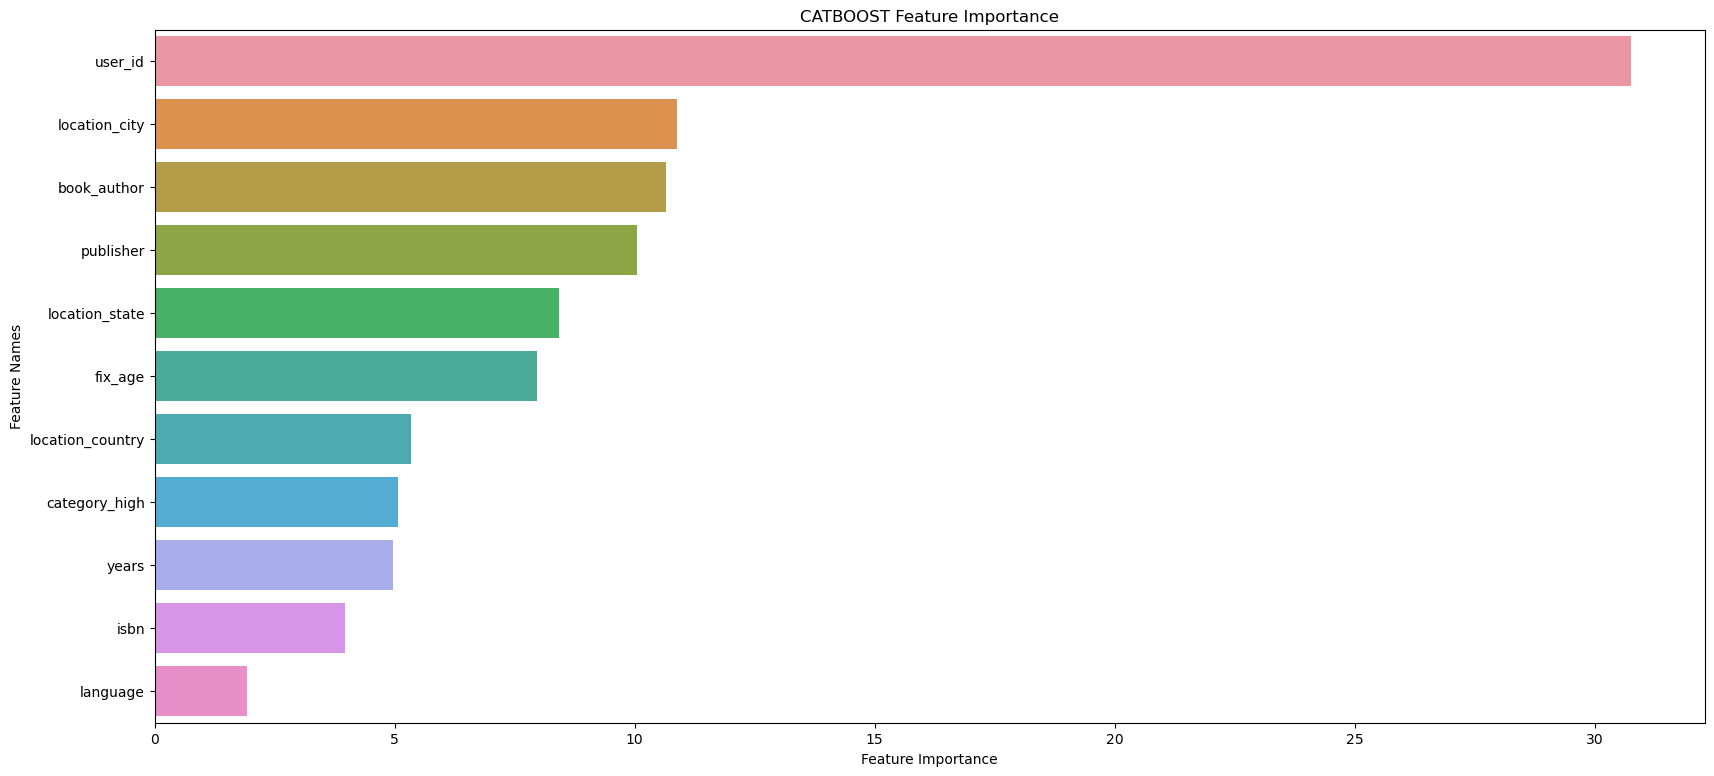

In [128]:
def plot_feature_importance(importance,names,model_type):
    
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(20,9))

    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')
    
    plt.show()


plot_feature_importance(model.get_feature_importance(), train_ratings.drop(['rating'],axis = 1).columns, 'CATBOOST')